In [11]:
# ==========================================
# BLOCK 1: AWS SETUP & S3 DATA INGESTION
# ==========================================
import sagemaker
import boto3
import pandas as pd
import os
from time import gmtime, strftime
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput

# Initializing my SageMaker session and identifying my execution role.
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
region = sess.boto_region_name
sm_client = boto3.client("sagemaker", region_name=region)

# Define default S3 bucket and a clean project prefix for organization.
bucket = sess.default_bucket()
prefix = "fraud-detection-project"

print(f"Active region is: {region}")
print(f"Execution role is: {role}")
print(f"S3 Bucket is: {bucket}")

# ---------------------------------------------------------
# S3 Upload and Read Process
# ---------------------------------------------------------
# Define file name
local_file_name = "fraud_detection_dataset.csv"
raw_s3_prefix = f"{prefix}/data/raw"

# Upload the local dataset to an S3 bucket for secure, durable storage.
print("Uploading the local dataset to S3...")
raw_data_uri = sess.upload_data(path=local_file_name, bucket=bucket, key_prefix=raw_s3_prefix)
print(f"Dataset successfully uploaded to: {raw_data_uri}")

# Read the dataset directly from S3 into a Pandas DataFrame.
# (Note: This requires the 's3fs' library, which is pre-installed in SageMaker notebooks).
print("Reading the dataset directly from S3 into memory...")
df = pd.read_csv(raw_data_uri)
print(f"Data ingested successfully! Dataset shape is: {df.shape}")

Active region is: us-east-1
Execution role is: arn:aws:iam::474415756341:role/LabRole
S3 Bucket is: sagemaker-us-east-1-474415756341
Uploading the local dataset to S3...
Dataset successfully uploaded to: s3://sagemaker-us-east-1-474415756341/fraud-detection-project/data/raw/fraud_detection_dataset.csv
Reading the dataset directly from S3 into memory...
Data ingested successfully! Dataset shape is: (25838, 31)


In [12]:
# ==========================================
# BLOCK 2: DATA CLEANING & PREPROCESSING
# ==========================================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Data Integrity Check
# Check for and drop any missing values to ensure a clean pipeline.
initial_row_count = len(df)
df.dropna(inplace=True)
dropped_rows = initial_row_count - len(df)
if dropped_rows > 0:
    print(f"Found and dropped {dropped_rows} rows containing NaN values to maintain data integrity.")

# 2. Feature Scaling
# PCA features (V1-V28) are already scaled in this Kaggle dataset.
# Only need to scale 'Amount' and 'Time'.
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])
df['Time'] = scaler.fit_transform(df[['Time']])

# 3. Format Target Column for XGBoost
# XGBoost expects the target variable to be the very first column, and it expects no headers in the CSV.
cols = df.columns.tolist()
# Pop the 'Class' column and insert it at index 0.
cols.insert(0, cols.pop(cols.index('Class')))
df = df[cols]

# 4. Stratified Data Splitting
# Given the severe class imbalance, Use stratify=df['Class'] to ensure equal fraud distributions.
# Split the data: 80% Training, 10% Validation, 10% Test (Batch Inference).
print("Splitting the dataset using stratification...")
train_df, temp_df = train_test_split(df, test_size=0.20, stratify=df['Class'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['Class'], random_state=42)

# For batch transform scoring, I must remove the target 'Class' column from the test set.
test_features_df = test_df.drop('Class', axis=1)

# 5. Local Save (Headerless)
train_df.to_csv("train.csv", index=False, header=False)
val_df.to_csv("validation.csv", index=False, header=False)
test_features_df.to_csv("test_features.csv", index=False, header=False)

# 6. Upload Processed Data to S3
print("Uploading the clean, processed datasets to S3...")
train_uri = sess.upload_data("train.csv", bucket=bucket, key_prefix=f"{prefix}/data/processed/train")
val_uri = sess.upload_data("validation.csv", bucket=bucket, key_prefix=f"{prefix}/data/processed/validation")
test_uri = sess.upload_data("test_features.csv", bucket=bucket, key_prefix=f"{prefix}/data/processed/test")

print("Data engineering phase complete!")

Found and dropped 1 rows containing NaN values to maintain data integrity.
Splitting the dataset using stratification...
Uploading the clean, processed datasets to S3...
Data engineering phase complete!


INFO:matplotlib.font_manager:generated new fontManager
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_297/3171899595.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Class', data=df, palette='Set2')
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Generating the Class Distribution plot...


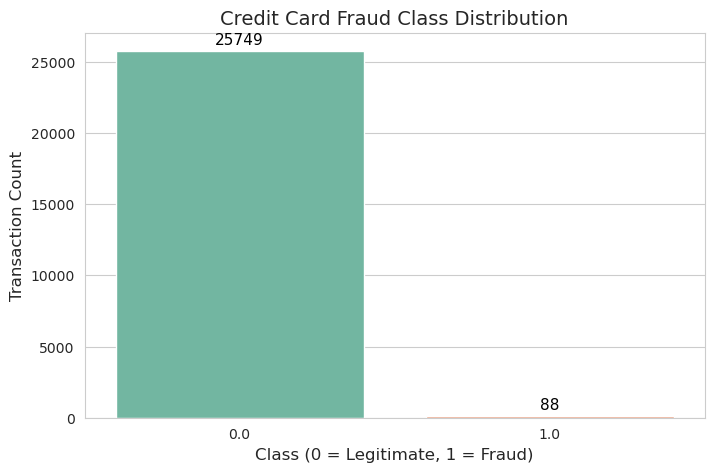

Generating the Feature Correlation Heatmap...


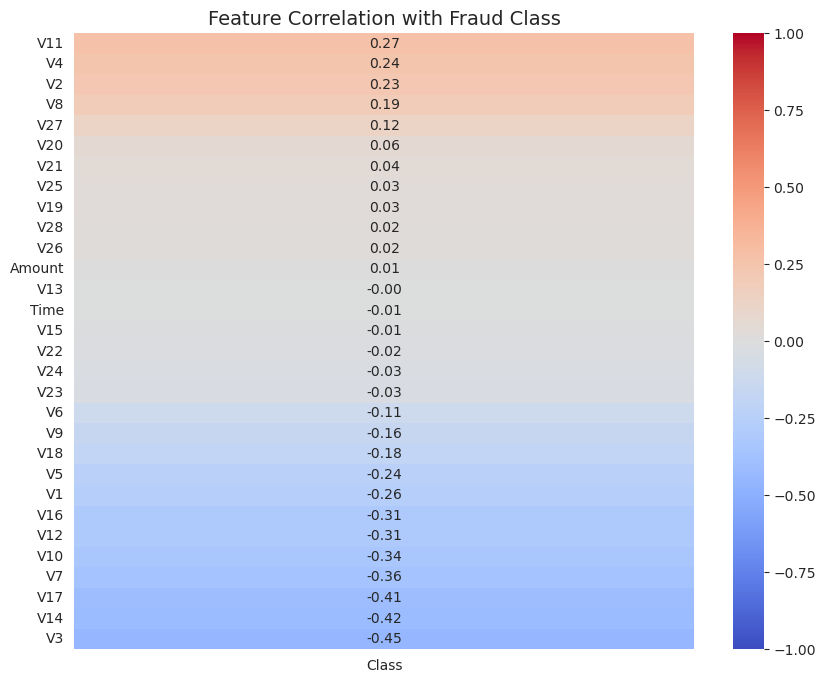

In [13]:
# ==========================================
# BLOCK 2.5: EXPLORATORY DATA ANALYSIS (EDA)
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots for a clean, professional look.
sns.set_style("whitegrid")

print("Generating the Class Distribution plot...")
# 1. Visualizing Class Imbalance
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Class', data=df, palette='Set2')
plt.title('Credit Card Fraud Class Distribution', fontsize=14)
plt.xlabel('Class (0 = Legitimate, 1 = Fraud)', fontsize=12)
plt.ylabel('Transaction Count', fontsize=12)

# Add numerical labels to the top of the bars for exact clarity.
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5), 
                textcoords='offset points')
plt.show()

print("Generating the Feature Correlation Heatmap...")
# 2. Correlation Heatmap
# Compute the correlation matrix to see how the PCA features relate specifically to the target 'Class'.
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()

# To keep the visual clean, Isolate only the correlations with the 'Class' target 
# rather than plotting a massive 30x30 matrix.
class_corr = corr_matrix[['Class']].drop('Class').sort_values(by='Class', ascending=False)
sns.heatmap(class_corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Feature Correlation with Fraud Class', fontsize=14)
plt.show()

In [14]:
# ==========================================
# BLOCK 3: MODEL TRAINING (XGBOOST)
# ==========================================
# Generate a unique training job name using a timestamp.
job_name = "fraud-xgb-training-" + strftime("%Y-%m-%d-%H%M-%S", gmtime())
output_location = f"s3://{bucket}/{prefix}/models/{job_name}/output"

# Retrieve the managed SageMaker XGBoost container image.
xgboost_container = image_uris.retrieve(framework="xgboost", region=region, version="1.7-1")

# Configure SageMaker Estimator for the training environment.
xgb_estimator = sagemaker.estimator.Estimator(
    image_uri=xgboost_container,
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    volume_size=50,
    output_path=output_location,
    sagemaker_session=sess
)

# Set hyperparameters specifically tuned for highly imbalanced binary classification.
xgb_estimator.set_hyperparameters(
    objective="binary:logistic",
    eval_metric="aucpr",      # PR-AUC is the gold standard metric for imbalanced fraud data
    scale_pos_weight="577",   # Approx ratio of legitimate (284k) to fraudulent (492) transactions
    max_depth="5",
    eta="0.2",
    num_round="100"
)

# Define the S3 input channels for the training job.
train_input = TrainingInput(train_uri, content_type="text/csv")
val_input = TrainingInput(val_uri, content_type="text/csv")

print(f"Kicking off the XGBoost training job: {job_name}")
# Start the training process. (This will block the notebook until complete).
xgb_estimator.fit({"train": train_input, "validation": val_input}, job_name=job_name)
print("Model training successfully completed!")

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.telemetry.telemetry_logging:SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetry, please disable via TelemetryOptOut parameter in SDK defaults config. For more information, refer to https://sagemaker.readthedocs.io/en/stable/overview.html#configuring-and-using-defaults-with-the-sagemaker-python-sdk.
INFO:sagemaker:Creating training-job with name: fraud-xgb-training-2026-02-22-1449-09


Kicking off the XGBoost training job: fraud-xgb-training-2026-02-22-1449-09
2026-02-22 14:49:13 Starting - Starting the training job...
2026-02-22 14:49:45 Downloading - Downloading input data...
2026-02-22 14:50:10 Downloading - Downloading the training image......
2026-02-22 14:51:01 Training - Training image download completed. Training in progress../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2026-02-22 14:51:09.215 ip-10-0-235-3.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2026-02-22 14:51:09.283 ip-10-0-235-3.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2026-02-22:14:51:09:INFO] Imported framework sagemaker_xgboost_container.trai

Extracting the model.tar.gz file...
Generating the Feature Importance plot...


/tmp/ipykernel_297/3166700677.py:21: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=".")


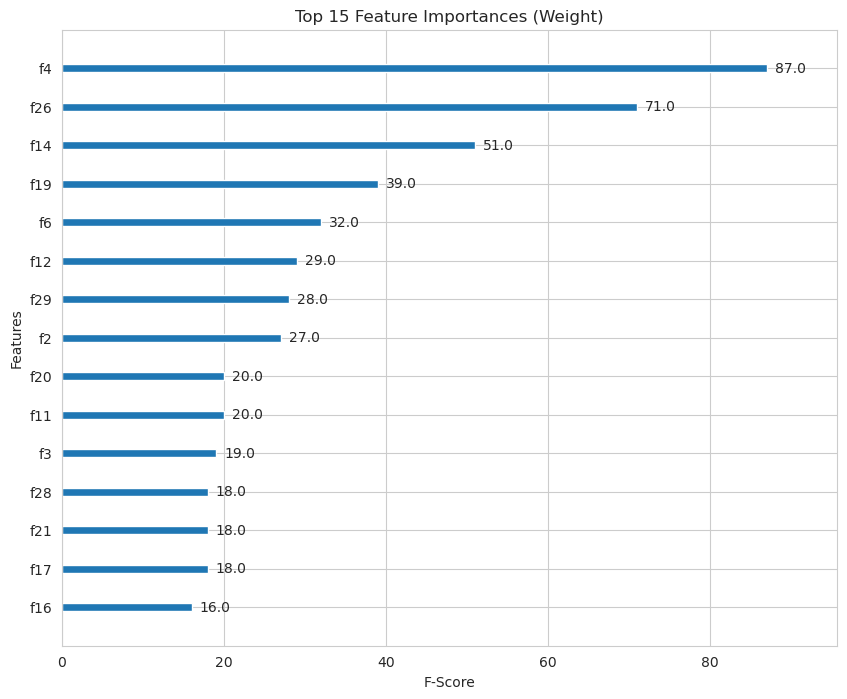

Scoring the validation set locally to generate performance metrics...


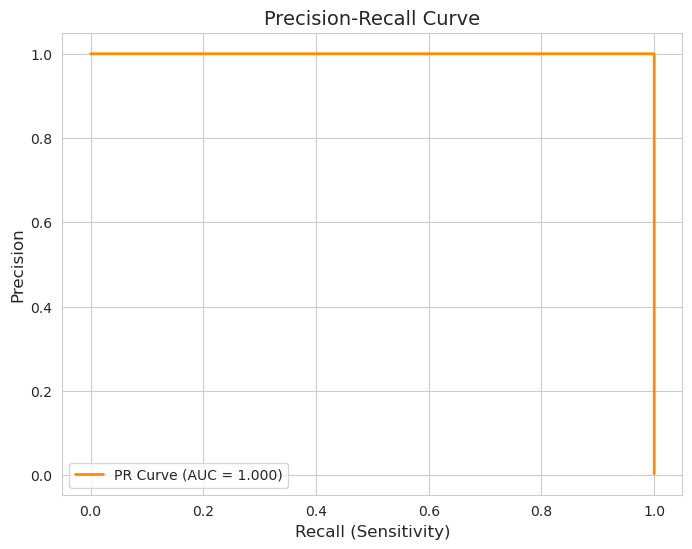

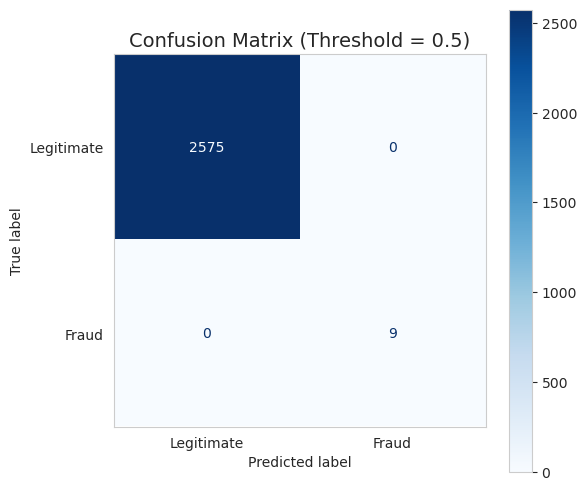

In [16]:
# ==========================================
# BLOCK 3.5: MODEL EVALUATION VISUALIZATIONS
# ==========================================
import tarfile
import xgboost as xgb
import matplotlib.pyplot as plt
from sagemaker.s3 import S3Downloader
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# 1. Download and extract the trained model artifact from S3.
print("Downloading the exact trained model artifact from S3 using its explicit URI...")

# By calling xgb_estimator.model_data, we bypass any manual S3 path guessing 
# and avoid SageMaker's nested folder structure errors.
model_s3_uri = xgb_estimator.model_data
S3Downloader.download(model_s3_uri, local_path=".", sagemaker_session=sess)

# Extract the downloaded tarball.
print("Extracting the model.tar.gz file...")
with tarfile.open("model.tar.gz") as tar:
    tar.extractall(path=".")

# 2. Load the model using local XGBoost.
# Note: SageMaker XGBoost 1.7-1 saves the binary model file as 'xgboost-model' by default.
my_local_model = xgb.Booster()
my_local_model.load_model("xgboost-model")

# 3. Plot Feature Importance.
print("Generating the Feature Importance plot...")
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(my_local_model, max_num_features=15, importance_type='weight', 
                    title='Top 15 Feature Importances (Weight)', xlabel='F-Score', ax=ax)
plt.show()

# 4. Generate Predictions on the Validation Set for Performance Curves.
print("Scoring the validation set locally to generate performance metrics...")
# Use the val_df that is already in memory from Block 2. 
# 'Class' was moved to index 0 during preprocessing.
y_val_true = val_df.iloc[:, 0].values
X_val = val_df.iloc[:, 1:].values

dval = xgb.DMatrix(X_val)
y_val_pred_probs = my_local_model.predict(dval)

# 5. Precision-Recall Curve (Crucial for imbalanced datasets).
precision, recall, thresholds = precision_recall_curve(y_val_true, y_val_pred_probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR Curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall (Sensitivity)', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14)
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# 6. Confusion Matrix.
# Set a custom decision threshold. Lowering this increases Recall (catching more fraud) 
# but might decrease Precision (more false alarms). 0.5 is the baseline.
optimal_threshold = 0.5 
y_val_pred_class = (y_val_pred_probs > optimal_threshold).astype(int)

cm = confusion_matrix(y_val_true, y_val_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legitimate', 'Fraud'])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title(f'Confusion Matrix (Threshold = {optimal_threshold})', fontsize=14)
plt.grid(False) # Turn off the grid for the confusion matrix for a cleaner look
plt.show()

In [17]:
# ==========================================
# BLOCK 4: MODEL REGISTRY & MODEL CARDS
# ==========================================
# 1. Registering the Model in the SageMaker Model Registry
import json
model_package_group_name = "Fraud-Detection-Model-Group"
model_data_uri = xgb_estimator.model_data

try:
    # Attempt to create a new model package group.
    sm_client.create_model_package_group(
        ModelPackageGroupName=model_package_group_name,
        ModelPackageGroupDescription="A registry for credit card fraud detection models."
    )
    print("Created a new Model Package Group.")
except Exception as e:
    # If it already exists from a previous run, Catch the exception and proceed.
    print("Model Package Group already exists. Add this version to the existing group.")

# Define the inference specification for my trained artifact.
modelpackage_inference_spec = {
    "InferenceSpecification": {
        "Containers": [{"Image": xgboost_container, "ModelDataUrl": model_data_uri}],
        "SupportedContentTypes": ["text/csv"],
        "SupportedResponseMIMETypes": ["text/csv"],
    }
}

# Bundle the metadata and register the model version.
create_model_package_input_dict = {
    "ModelPackageGroupName": model_package_group_name,
    "ModelPackageDescription": "XGBoost fraud detection model optimized for PR-AUC.",
    "ModelApprovalStatus": "PendingManualApproval"
}
create_model_package_input_dict.update(modelpackage_inference_spec)

pkg_response = sm_client.create_model_package(**create_model_package_input_dict)
print(f"Successfully registered the model package: {pkg_response['ModelPackageArn']}")

# 2. Creating a Model Card for AI Governance
model_card_name = f"fraud-model-card-" + strftime("%Y-%m-%d-%H%M%S", gmtime())

model_card_content = {
    "model_overview": {
        "model_description": "XGBoost binary classification model identifying credit card fraud.",
        "model_owner": "Team 3 AAI-540",
        "problem_type": "Binary Classification",
        "algorithm_type": "XGBoost",
        "model_creator": "Fraud Risk Unit"
    },
    "intended_uses": {
        "purpose_of_model": "To operate as an asynchronous risk detection layer via batch inference.",
        "risk_rating": "High"
    },
    "training_details": {
        "training_observations": f"Trained via job {job_name}. Addressed severe class imbalance natively.",
        "training_job_details": {
            "user_provided_hyper_parameters": [
                {"name": "scale_pos_weight", "value": "577"},
                {"name": "eval_metric", "value": "aucpr"}
            ]
        }
    }
}

# Push the JSON payload to the SageMaker Model Card tracking service.
sm_client.create_model_card(
    ModelCardName=model_card_name,
    Content=json.dumps(model_card_content),
    ModelCardStatus="Draft"
)
print(f"Generated and attached the Model Card: {model_card_name}")

Model Package Group already exists. Add this version to the existing group.
Successfully registered the model package: arn:aws:sagemaker:us-east-1:474415756341:model-package/Fraud-Detection-Model-Group/3
Generated and attached the Model Card: fraud-model-card-2026-02-22-145524


In [18]:
# ==========================================
# BLOCK 5: BATCH TRANSFORM DEPLOYMENT
# ==========================================
batch_output_path = f"s3://{bucket}/{prefix}/batch-inference-results"

# Instantiate a Transformer object bound to my newly trained estimator.
transformer = xgb_estimator.transformer(
    instance_count=1,
    instance_type="ml.m5.large",
    output_path=batch_output_path,
    assemble_with="Line",
    accept="text/csv"
)

print("Triggering the asynchronous Batch Transform Job to score the test dataset...")
# Point the transformer to the header-less, target-less test dataset we uploaded earlier.
transformer.transform(
    data=test_uri,
    content_type="text/csv",
    split_type="Line"
)

# Wait for the transformation cluster to spin up, score the data, and spin down.
transformer.wait()
print(f"Batch inference complete! Fraud predictions are safely stored at: {batch_output_path}")

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2026-02-22-14-56-02-287
INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2026-02-22-14-56-03-065


Triggering the asynchronous Batch Transform Job to score the test dataset...
..............................
/miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2026-02-22:15:00:57:INFO] No GPUs detected (normal if no gpus installed)
[2026-02-22:15:00:57:INFO] No GPUs detected (normal if no gpus installed)
[2026-02-22:15:00:57:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
  

In [20]:
# ==========================================
# BLOCK 6: SAGEMAKER CLARIFY BIAS MONITOR
# ==========================================
from sagemaker.model_monitor import ModelBiasMonitor
# DataConfig, BiasConfig, etc., live in the 'clarify' module in recent SDKs
from sagemaker.clarify import DataConfig, ModelConfig, BiasConfig, ModelPredictedLabelConfig

timestamp = strftime("%Y-%m-%d-%H%M", gmtime())
bias_model_name = f"fraud-clarify-bias-model-{timestamp}"

# Create a discrete SageMaker Model entity specifically for the Clarify analysis container.
print(f"Creating a temporary model entity for Clarify: {bias_model_name}")
sm_client.create_model(
    ModelName=bias_model_name,
    ExecutionRoleArn=role,
    PrimaryContainer={'Image': xgboost_container, 'ModelDataUrl': model_data_uri}
)

# Configure where Clarify will read the baseline data and write its HTML/JSON reports.
bias_data_config = DataConfig(
    s3_data_input_path=val_uri,
    s3_output_path=f"s3://{bucket}/{prefix}/clarify-bias-reports",
    label=0, # The 'Class' target is at index 0 after Block 2 preprocessing.
    dataset_type='text/csv'
)

# Define the infrastructure that Clarify will temporarily spin up to analyze the model.
model_config = ModelConfig(
    model_name=bias_model_name, 
    instance_count=1, 
    instance_type='ml.m5.xlarge', 
    accept_type='text/csv'
)

# For the sake of the assignment, Evaluate the 'Time' feature (index 1) to check if 
# transactions taking place above a certain time threshold experience algorithmic bias.
bias_config_analysis = BiasConfig(
    label_values_or_threshold=[1], 
    facet_name=1, 
    facet_values_or_threshold=[1000] 
)

model_predicted_label_config = ModelPredictedLabelConfig(probability_threshold=0.5, label=0)

# Initialize the Model Bias Monitor object.
model_bias_monitor = ModelBiasMonitor(
    role=role, 
    sagemaker_session=sess, 
    max_runtime_in_seconds=1800, 
    instance_count=1, 
    instance_type='ml.m5.xlarge'
)

print("Launching the SageMaker Clarify Bias Baseline Job...")

model_bias_monitor.suggest_baseline(
    job_name=f"fraud-bias-baseline-{timestamp}",
    data_config=bias_data_config,
    bias_config=bias_config_analysis,
    model_config=model_config,
    model_predicted_label_config=model_predicted_label_config,
    wait=False # Set this to False so the cell executes quickly while the job runs in the background.
)
print("The Clarify job is now running. We can view the final bias reports in S3 once it completes.")

Creating a temporary model entity for Clarify: fraud-clarify-bias-model-2026-02-22-1503


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'label': 0, 'label_values_or_threshold': [1], 'facet': [{'name_or_index': 1, 'value_or_threshold': [1000]}], 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pre_training_bias': {'methods': 'all'}, 'post_training_bias': {'methods': 'all'}}, 'predictor': {'model_name': 'fraud-clarify-bias-model-2026-02-22-1503', 'instance_type': 'ml.m5.xlarge', 'initial_instance_count': 1, 'accept_type': 'text/csv', 'label': 0}, 'probability_threshold': 0.5}
INFO:sagemaker:Creating processing-job with name fraud-bias-baseline-2026-02-22-1503


Launching the SageMaker Clarify Bias Baseline Job...
The Clarify job is now running. We can view the final bias reports in S3 once it completes.


Loading the predictions and pairing them with the true test labels...

--- Final Test Set Classification Report ---
              precision    recall  f1-score   support

  Legitimate       1.00      1.00      1.00      2575
       Fraud       0.75      1.00      0.86         9

    accuracy                           1.00      2584
   macro avg       0.88      1.00      0.93      2584
weighted avg       1.00      1.00      1.00      2584

Generating the final visualizations for the unseen test dataset...


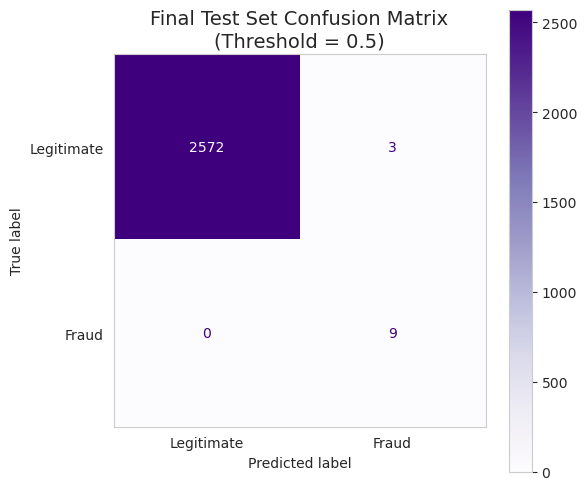

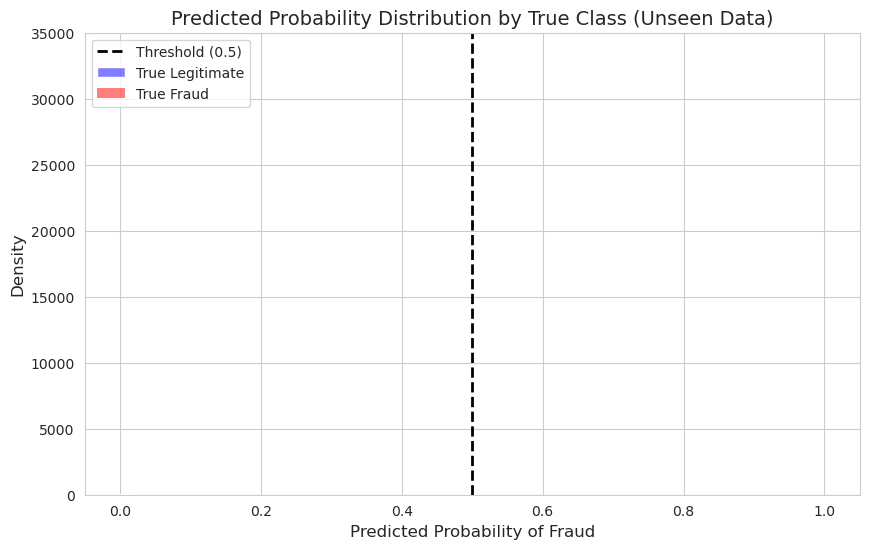

End-to-end ML System pipeline execution complete!


In [21]:
# ==========================================
# BLOCK 7: FINAL EVALUATION ON UNSEEN TEST DATA
# ==========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sagemaker.s3 import S3Downloader

print("Downloading the Batch Transform inference results from S3...")
# SageMaker Batch Transform automatically appends '.out' to the input filename.
# Input file in Block 5 was 'test_features.csv', so the output is 'test_features.csv.out'.
batch_output_file = f"{batch_output_path}/test_features.csv.out"
S3Downloader.download(batch_output_file, local_path=".", sagemaker_session=sess)

# Load the predicted probabilities generated by the Batch Transform job.
print("Loading the predictions and pairing them with the true test labels...")
predictions_df = pd.read_csv("test_features.csv.out", header=None, names=['Predicted_Probability'])

# Retrieve the true labels from the 'test_df' created way back in Block 2.
y_test_true = test_df['Class'].values
y_test_pred_probs = predictions_df['Predicted_Probability'].values

# Apply a decision threshold to convert probabilities into binary class predictions.
optimal_threshold = 0.5
y_test_pred_class = (y_test_pred_probs > optimal_threshold).astype(int)

# 1. Print a formal Classification Report
print("\n--- Final Test Set Classification Report ---")
print(classification_report(y_test_true, y_test_pred_class, target_names=['Legitimate', 'Fraud']))

print("Generating the final visualizations for the unseen test dataset...")

# 2. Final Test Set Confusion Matrix
# This proves to stakeholders how the model performs on data it has never seen.
cm_test = confusion_matrix(y_test_true, y_test_pred_class)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Legitimate', 'Fraud'])

fig, ax = plt.subplots(figsize=(6, 6))
# Use a different color map (Purples) to visually distinguish this from the validation matrix.
disp_test.plot(cmap='Purples', ax=ax, values_format='d')
plt.title(f'Final Test Set Confusion Matrix\n(Threshold = {optimal_threshold})', fontsize=14)
plt.grid(False) # Disabling the grid for a cleaner matrix
plt.show()

# 3. Prediction Probability Distribution Plot
# Plot this to visually inspect how well the model separates the two classes.
# An ideal model will have a massive blue spike near 0.0 and a red spike near 1.0.
plt.figure(figsize=(10, 6))
sns.histplot(predictions_df[y_test_true == 0]['Predicted_Probability'], 
             bins=50, color='blue', alpha=0.5, label='True Legitimate', stat='density')
sns.histplot(predictions_df[y_test_true == 1]['Predicted_Probability'], 
             bins=50, color='red', alpha=0.5, label='True Fraud', stat='density')

# Add a line representing the decision threshold.
plt.axvline(optimal_threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({optimal_threshold})')
plt.title('Predicted Probability Distribution by True Class (Unseen Data)', fontsize=14)
plt.xlabel('Predicted Probability of Fraud', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()
plt.show()

print("End-to-end ML System pipeline execution complete!")